# First version of AE

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import keras
from keras import layers
from keras.models import load_model, Model
from keras import backend as K
from keras.layers import Layer
from keras.losses import KLDivergence
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.model_selection import train_test_split
import datetime
import time

2024-05-21 11:46:10.490277: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 11:46:11.226364: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 11:46:11.954718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 11:46:23.367619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(tf.__version__)
print(keras.__version__)
%load_ext tensorboard

2.16.1
3.3.3


## Preprocessing

### Load dataset

On importe le dataset baron et on applique le prétraitement habituel

In [4]:
filename="./dataset/barondata_rawcounts.csv"
data_baron=pd.read_csv(filename, sep=';', comment="#", index_col=0)
data_baron

,human1_lib1.final_cell_0001,human1_lib1.final_cell_0002,human1_lib1.final_cell_0003,human1_lib1.final_cell_0004,human1_lib1.final_cell_0005,human1_lib1.final_cell_0006,human1_lib1.final_cell_0007,human1_lib1.final_cell_0008,human1_lib1.final_cell_0009,human1_lib1.final_cell_0010,...,human4_lib3.final_cell_0692,human4_lib3.final_cell_0693,human4_lib3.final_cell_0694,human4_lib3.final_cell_0695,human4_lib3.final_cell_0696,human4_lib3.final_cell_0697,human4_lib3.final_cell_0698,human4_lib3.final_cell_0699,human4_lib3.final_cell_0700,human4_lib3.final_cell_0701
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,4,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,0,1,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
ZYX,2,4,0,3,1,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
ZZEF1,0,0,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
ZZZ3,0,1,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
filename="./dataset/barondata_annotations.csv"
annotations_baron=pd.read_csv(filename, sep=';', comment="#", index_col=0)
annotations_baron = annotations_baron.drop(columns=['donor'])
annotations_baron

,label
human1_lib1.final_cell_0001,acinar
human1_lib1.final_cell_0002,acinar
human1_lib1.final_cell_0003,acinar
human1_lib1.final_cell_0004,acinar
human1_lib1.final_cell_0005,acinar
...,...
human4_lib3.final_cell_0697,activated_stellate
human4_lib3.final_cell_0698,alpha
human4_lib3.final_cell_0699,beta
human4_lib3.final_cell_0700,beta


In [6]:
data_ann=sc.AnnData(data_baron.T)
data_ann

AnnData object with n_obs × n_vars = 8569 × 20125

In [7]:
data_ann.obs['label'] = annotations_baron['label']

### Filter data

On filtre les données de manière peu stricte

In [8]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

In [9]:
data_ann.raw = data_ann.copy()

In [10]:
#data_ann.obs['size_factors'] = 1.0

### Normalize and scale

In [11]:
sc.pp.normalize_total(data_ann)
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
sc.pp.log1p(data_ann)


In [12]:
sc.pp.scale(data_ann)

### Explore the result

In [13]:
data_ann.var

,n_cells,mean,std
A1BG,42,0.003199,0.049455
A1CF,1408,0.132453,0.327797
A2M,273,0.029914,0.180720
A4GALT,444,0.043716,0.203291
AAAS,1216,0.104913,0.285008
...,...,...,...
ZYG11B,1394,0.119749,0.299532
ZYX,2691,0.289623,0.489316
ZZEF1,1225,0.106196,0.283994
ZZZ3,872,0.074865,0.243036


## Create autoencoder

Premiere version de la zinb loss


In [14]:
def negative_binomial_loss(y_true, y_pred):
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    y_true = tf.cast(y_true, dtype='float32')
    #print(type(mu), mu)
    #print(type(pi),pi)
    #print(type(theta), theta)
    #print(type(y_true), y_true)


    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2
    final = tf.reduce_mean(final)
    return final

def zero_inflated_negative_binomial_loss(y_true, y_pred):
    input_shape=int(y_pred.shape[1]/3)
    mu = y_pred[:, :input_shape]
    pi = y_pred[:, input_shape:input_shape*2]
    theta = y_pred[:, input_shape*2:]
    y_true = tf.cast(y_true, dtype='float32')
    #print(type(mu), mu)
    #print(type(pi),pi)
    #print(type(theta), theta)
    #print(type(y_true), y_true)


    eps = 1e-10
    t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
    t2 = (theta+y_true) * tf.math.log(1.0 + (mu/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(mu+eps)))
    final=t1 + t2

    nb_case = t1 + t2 - tf.math.log(1.0-pi+eps)
    zero_nb = tf.pow(theta/(theta+mu+eps), theta)
    zero_case = -tf.math.log(pi + ((1.0-pi)*zero_nb)+eps)
    result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
    #ridge = self.ridge_lambda*tf.square(self.pi)
    #result += ridge
    result = tf.reduce_mean(result)
    return result

MeanAct = lambda x: tf.clip_by_value(tf.keras.backend.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.keras.backend.softplus(x), 1e-4, 1e4)

ColWiseMultLayer = lambda name: layers.Lambda(lambda l: l[0]*(tf.matmul(tf.reshape(l[1], (-1,1)),
                                                                 tf.ones((1, l[0].get_shape()[1]),
                                                                         dtype=l[1].dtype))), name=name)

In [15]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters=n_clusters
        self.alpha=alpha
        self.intial_weights=weights
        #self.input_spec=keras.InputSpec(ndim=2) #to specify the expected rank of the input

    def build(self, input_shape):
        input_dim=input_shape[1]
        #self.input_spec=keras.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.intial_weights is not None :
            self.set_weights(self.intial_weights)
            del self.intial_weights
        self.built=True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (tf.math.reduce_sum(tf.math.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = tf.transpose(tf.transpose(q) / tf.math.reduce_sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [16]:
def create_autoencoder(input_shape, noise):
    init='glorot_uniform'
    Inputs = layers.Input(shape=(input_shape,), name='Inputs')
    sf_layer=layers.Input(shape=(1,), name="size_factors")
    x=layers.GaussianNoise(noise)(Inputs)
    x=layers.Dense(256, activation='relu',kernel_initializer=init, name='encoder_1' )(x)
    x=layers.GaussianNoise(noise)(x)
    x=layers.Dense(64, activation='relu',kernel_initializer=init, name='encoder_2' )(x)
    x=layers.GaussianNoise(noise)(x)
    hidden=layers.Dense(32, activation='relu',kernel_initializer=init, name='encoder_3' )(x)


    x=layers.Dense(32, activation='relu',kernel_initializer=init, name='decoder_1' )(hidden)
    x=layers.Dense(64, activation='relu',kernel_initializer=init, name='decoder_2' )(x)
    x=layers.Dense(256, activation='relu',kernel_initializer=init, name='decoder_3' )(x)
    pi=layers.Dense(input_shape, activation="sigmoid",kernel_initializer=init, name='pi')(x)
    disp=layers.Dense(input_shape, activation=DispAct,kernel_initializer=init, name='dispersion')(x)
    mean=layers.Dense(input_shape, activation=MeanAct,kernel_initializer=init, name='mean')(x)

    Outputs=ColWiseMultLayer(name='outputs')([mean, sf_layer])
    #Outputs=SliceLayer(0, name='slice')([Outputs, disp, pi])
    outputs = layers.Concatenate(axis=1, name='output')([Outputs, pi, disp])

    autoencoder=Model([Inputs, sf_layer], outputs, name='autoencoder_ZINB')
    autoencoder.compile(optimizer='adam', loss={'output': zero_inflated_negative_binomial_loss})

    autoencoder.summary()
    return autoencoder

In [17]:
def kld(y_true, y_pred):
    return KLDivergence(y_true, y_pred)

In [21]:
def display_latent_space(y_pred, model, count_data_hvg , size_factors, obs):
    encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
    encoder.summary()
    predict_data=encoder.predict([count_data_hvg, size_factors])
    adata_latent = sc.AnnData(predict_data)
    adata_latent.obs=obs
    adata_latent.obs['predict']=y_pred
    anno=adata_latent.obs['label']
    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    sc.pl.umap(adata_latent, color="label")
    sc.pl.umap(adata_latent, color="predict")
    crosstab = pd.crosstab(y_pred,anno)
    sns.heatmap(crosstab, annot=True, cmap='Blues')
    plt.ylabel('Clusters prédits')
    plt.xlabel('Annotations réelles')
    plt.title('Matrice de confusion')
    plt.show()

In [29]:
def target_distribution(q):
    weight = q**2/q.sum(0)
    return (weight.T/weight.sum(1)).T

def auto_kmeans(encoder, x_counts, size_factors, obs, plot=False):
    y=obs["label"]
    ari=[]
    nmi=[]
    x=[]
    for n in range (1,20):
        kmeans=KMeans(n_clusters=n, n_init=30, verbose=0)
        y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
        ari.append(adjusted_rand_score(y, y_pred))
        nmi.append(normalized_mutual_info_score(y, y_pred))
        x.append(n)
    somme_metriques = [x + y for x, y in zip(ari, nmi)]
    n_max=(somme_metriques.index(max(somme_metriques))+1)
    
    kmeans=KMeans(n_clusters=n_max, n_init=20)
    y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
    
    if plot==True:
        predict_data=encoder.predict([x_counts, size_factors])
        adata_latent = sc.AnnData(predict_data)
        adata_latent.obs=obs
        adata_latent.obs["kmeans"]=y_pred
        sc.pp.neighbors(adata_latent)
        sc.tl.umap(adata_latent)
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        ari = adjusted_rand_score(y, y_pred)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, y_pred)
        print("Normalized mutual info (NMI) :", nmi)
        sc.pl.umap( adata_latent, color=["kmeans"], legend_loc="on data")
        plt.plot()
    return y_pred, n_max, kmeans.cluster_centers_

def auto_leiden(encoder, x_counts, size_factors, obs, plot=False):
    y=obs["label"]
    predict_data=encoder.predict([x_counts, size_factors])
    adata_latent = sc.AnnData(predict_data)
    adata_latent.obs=obs
    sc.pp.neighbors(adata_latent)
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    x=[]
    
    #search for the best resolution
    for i in range (1,10):
        sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
        predict_cluster=adata_latent.obs["leiden"]
        list_ari.append(adjusted_rand_score(y, predict_cluster))
        list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
        x.append(i/100)
    for i in range (1,11):
        sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
        predict_cluster=adata_latent.obs["leiden"]
        list_ari.append(adjusted_rand_score(y, predict_cluster))
        list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
        x.append(i/10)
    somme_metriques = [x + y for x, y in zip(list_ari, list_nmi)]
    res_max=x[somme_metriques.index(max(somme_metriques))]
    print("La résolution est de : ", res_max)
    
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res_max), resolution=res_max)
    predict=adata_latent.obs["leiden_res_%.4f" % (res_max)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #set of plot if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,list_nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        sc.pl.umap( adata_latent, color=["leiden_res_%.4f" % (res_max)], legend_loc="on data")
        plt.plot()
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return predict, n_clusters, cluster_centers
    
def split(x_counts, raw_counts, size_factors, y):
    train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)
    x_train=x_counts[train_idx]
    x_test=x_counts[test_idx]
    size_factors_train=size_factors[train_idx]
    size_factors_test=size_factors[test_idx]
    raw_train=raw_counts[train_idx]
    raw_test=raw_counts[test_idx]
    y_train=y[train_idx]
    y_test=y[test_idx]
    print("Size of train set : ", x_train.shape)
    print("Size of test set : ", x_test.shape)
    return x_train, x_test, size_factors_train, size_factors_test, raw_train, raw_test, y_train, y_test


def fit(x_counts, obs, size_factors, raw_counts, alpha, n_cluster="auto", noise=0.5, batch_size=256,
        method="leiden", max_iter=2e4, tol=1e-3, update_interval=140,
        ae_weights=None, pretrained=False):
    print('Update interval', update_interval)
    t0 = time.time()
    print(x_counts.shape)
    input_shape=x_counts.shape[1]
    y=obs["label"]
    #step 0 split data
    x_train, x_test, size_factors_train, size_factors_test, raw_train, raw_test, y_train, y_test=split(x_counts, raw_counts, size_factors, y)
    input_shape=x_train.shape[1]
    #Step 1 Pretrain 
    if pretrained==False or ae_weights is None :
        print("..pretraining autoencoder : ")
        autoencoder=create_autoencoder(input_shape, noise)
        callback= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode='min', verbose=1)
        autoencoder.fit(x=[x_train, size_factors_train], y=raw_train, validation_data=([x_test,size_factors_test], raw_test), batch_size=batch_size, epochs=200, callbacks=[callback])
        autoencoder.save_weights("./model/weights/ae.weights.h5")
        ae_weights="./model/weights/ae.weights.h5"

    ae_layers = [l for l in autoencoder.layers]
    hidden = autoencoder.input[0]
    for i in range(1, len(ae_layers)):
        if "noise" in ae_layers[i].name:
            next
        elif "dropout" in ae_layers[i].name:
            next
        else:
            hidden = ae_layers[i](hidden)
        if "encoder_3" in ae_layers[i].name:  # only get encoder layers
             break
    encoder = Model(inputs=autoencoder.input, outputs=hidden, name='encoder')
    encoder.summary()


     #step 2 intialize clusters:
    
    #récupérons l'autoencoder
    #encoder= Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("hidden").output)
    if method=="leiden":
        print("Initializing cluster centers with leiden : ")
        y_pred, n_cluster, cluster_centers = auto_leiden(encoder, x_counts, size_factors, obs, plot=True)
        print('Le nombre de clusters est : ', n_cluster)
    elif method=="kmeans":
        print("Initializing cluster centers with k-means : ")
        if n_cluster=="auto":
            y_pred, n_cluster, cluster_centers =auto_kmeans(encoder, x_counts, size_factors, obs, plot=True)
            print('Le nombre de clusters est : ', n_cluster)
        else :
            kmeans=KMeans(n_clusters=n_cluster, n_init=20)
            y_pred=kmeans.fit_predict(encoder.predict([x_counts, size_factors]))
            cluster_centers=kmeans.cluster_centers_
    y_pred_last=np.copy(y_pred)
    
    clustering_layer = ClusteringLayer(n_cluster, alpha=alpha, name='clustering')(hidden)
    model= Model(inputs=[autoencoder.input[0], autoencoder.input[1]],
                           outputs=[clustering_layer, autoencoder.output])
    model.summary()
    model.compile(loss={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss}, optimizer='adam', metrics={'clustering': KLDivergence, 'output': zero_inflated_negative_binomial_loss})
    
    print("Set clustering weights")
    model.get_layer(name='clustering').set_weights([cluster_centers])
    print("Done")

    #step 3 deep clustering
    print("..Starting Deep Clustering")
    loss=[0,0,0]
    index=0
    save_interval = int(x_counts.shape[0] / batch_size) * 5
    for iteration in range(int(max_iter)):

        if iteration % update_interval==0:
            q,_= model.predict([x_counts, size_factors], verbose=0)
            p=target_distribution(q)

            y_pred=q.argmax(1)
            if y is not None :
                nmi=np.round(normalized_mutual_info_score(y, y_pred), 5)
                ari=np.round(adjusted_rand_score(y, y_pred), 5)
                loss=np.round(loss, 5)
                print('Iter-%d: NMI= %.4f, ARI= %.4f;  L= %.5f, Lc= %.5f,  Lr= %.5f'
                          % (iteration, nmi, ari, loss[0], loss[1], loss[2]))
            #stop criterion
            delta_label=np.sum(y_pred != y_pred_last).astype(np.float32)/y_pred.shape[0]
            y_pred_last=np.copy(y_pred)
            if iteration >0 and delta_label<tol:
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
                break
            
            if iteration==0:
                display_latent_space(y_pred, model, x_counts , size_factors, obs)
                
        #history=model.fit(x=[x_counts, size_factors], y=[p, raw_counts], batch_size=256, epochs=1, verbose=1)
        #print(history.history.keys())
        
        if (index + 1)*batch_size > x_counts.shape[0]:
            loss=model.train_on_batch(x=[x_counts[index * batch_size::], size_factors[index * batch_size:]],
                                                 y=[p[index * batch_size::], raw_counts[index * batch_size::]])
            index=0
        else:
            loss = model.train_on_batch(x=[x_counts[index * batch_size:(index + 1) * batch_size],
                                                    size_factors[index * batch_size:(index + 1) * batch_size]],
                                                 y=[p[index * batch_size:(index + 1) * batch_size],
                                                    raw_counts[index * batch_size:(index + 1) * batch_size]])
            index += 1
        #print(loss)
        
        if iteration % save_interval == 0:
            # save scDeepCluster model checkpoints
            #print('saving model to: ''/weights' + str(iteration) + '.h5')
            #model.save_weights('/weights' + str(iteration) + '.h5')
            print('saving model to: model/model.weights.h5')
            model.save_weights('model/model.weights.h5')

        #iteration+=1

    #acc = np.round(cluster_acc(y, y_pred), 5)
    nmi = np.round(normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(adjusted_rand_score(y, y_pred), 5)
    print('Final: NMI= %.4f, ARI= %.4f' % ( nmi, ari))
    print('Clustering time: %d seconds.' % int(time.time() - t0))

    return y_pred, model

Update interval 5
(8569, 17499)


/tmp/ipykernel_32510/2418414066.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_train=size_factors[train_idx]
/tmp/ipykernel_32510/2418414066.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factors_test=size_factors[test_idx]
/tmp/ipykernel_32510/2418414066.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_32510/2418414066.py:117: FutureWarning: Series.__getitem__

Size of train set :  (6855, 17499)
Size of test set :  (1714, 17499)
..pretraining autoencoder : 


Model: "autoencoder_ZINB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 17499)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_6    │ (None, 17499)     │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │  4,480,000 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_7    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_8    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 17499)     │  4,497,243 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 17499)     │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 17499)     │  4,497,243 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 17499)     │  4,497,243 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 52497)     │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,010,065 (68.70 MB)

 Trainable params: 18,010,065 (68.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.4832 - val_loss: 0.3497
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 926ms/step - loss: 0.3522 - val_loss: 0.3414
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 980ms/step - loss: 0.3432 - val_loss: 0.3378
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 963ms/step - loss: 0.3376 - val_loss: 0.3353
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.3381 - val_loss: 0.3341
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 0.3345 - val_loss: 0.3333
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 0.3355 - val_loss: 0.3324
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.3322 - val_loss: 0.3315
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.3320 - val_loss: 0.3312
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.3288 - val_loss: 0.3307
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 866ms/step - loss: 0.3287 - val_loss: 0.3306
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 872ms/s

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 17499)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │  4,480,000 │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ encoder_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,498,528 (17.16 MB)

 Trainable params: 4,498,528 (17.16 MB)

 Non-trainable params: 0 (0.00 B)

Initializing cluster centers with leiden : 
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
La résolution est de :  0.06


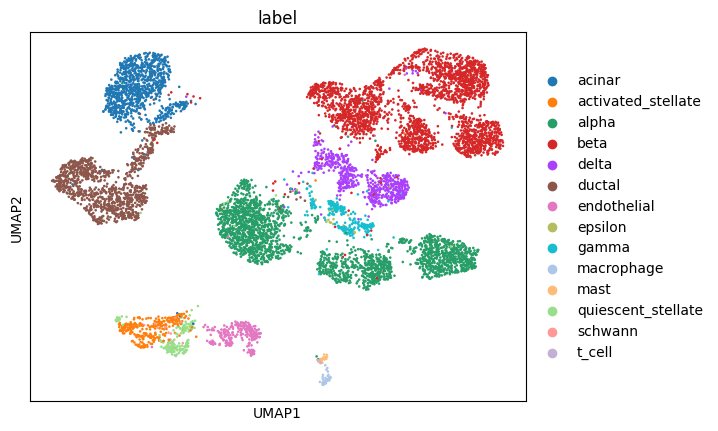

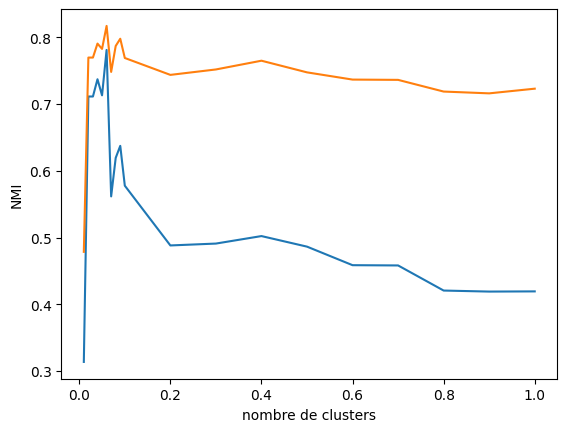

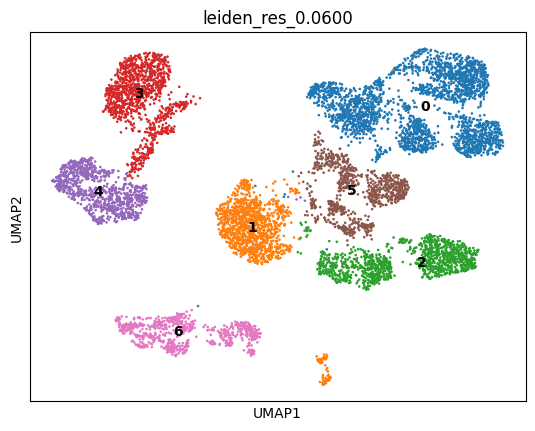

Indice de Rand ajusté (ARI) : 0.7812133470070769
Normalized mutual info (NMI) : 0.8171723497988992
Le nombre de clusters est :  7


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 17499)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_6    │ (None, 17499)     │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │  4,480,000 │ gaussian_noise_6… │
│                     │                   │            │ Inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_7    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
│                     │                   │            │ encoder_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_8    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
│                     │                   │            │ encoder_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Dense)   │ (None, 32)        │      1,056 │ encoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 64)        │      2,112 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_3 (Dense)   │ (None, 256)       │     16,640 │ decoder_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 17499)     │  4,497,243 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Lambda)    │ (None, 17499)     │          0 │ mean[0][0],       │
│                     │                   │            │ size_factors[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi (Dense)          │ (None, 17499)     │  4,497,243 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dispersion (Dense)  │ (None, 17499)     │  4,497,243 │ decoder_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clustering          │ (None, 7)         │        224 │ encoder_3[1][0]   │
│ (ClusteringLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 52497)     │          0 │ outputs[0][0],    │
│ (Concatenate)       │                   │            │ pi[0][0],         │
│                     │                   │            │ dispersion[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,010,289 (68.70 MB)

 Trainable params: 18,010,289 (68.70 MB)

 Non-trainable params: 0 (0.00 B)

Set clustering weights
Done
..Starting Deep Clustering
Iter-0: NMI= 0.7883, ARI= 0.7633;  L= 0.00000, Lc= 0.00000,  Lr= 0.00000


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 17499)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_6    │ (None, 17499)     │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │  4,480,000 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_7    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_8    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,498,528 (17.16 MB)

 Trainable params: 4,498,528 (17.16 MB)

 Non-trainable params: 0 (0.00 B)

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


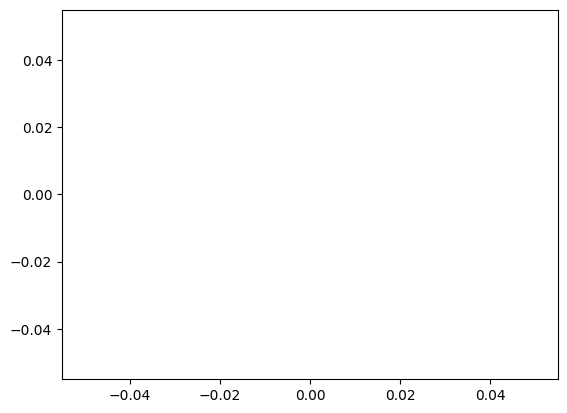

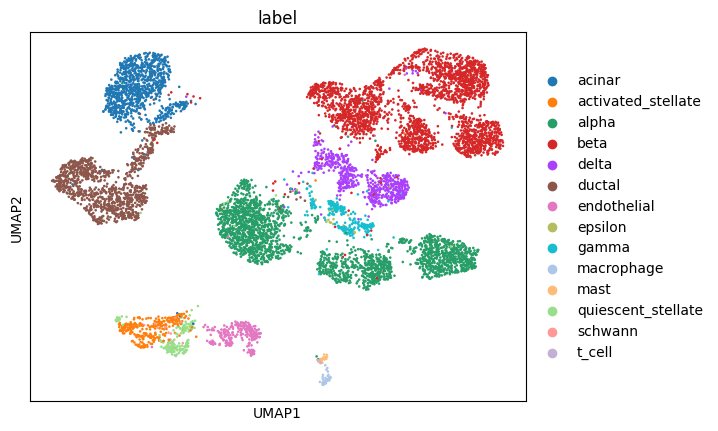

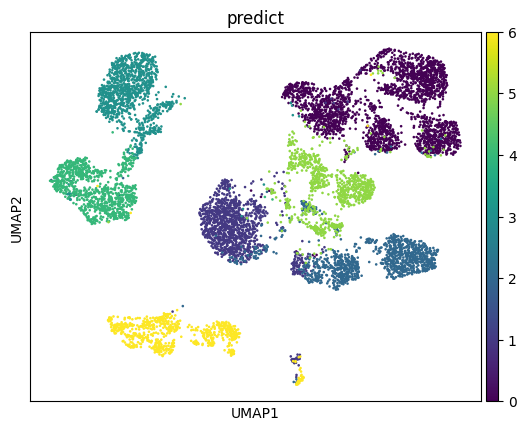

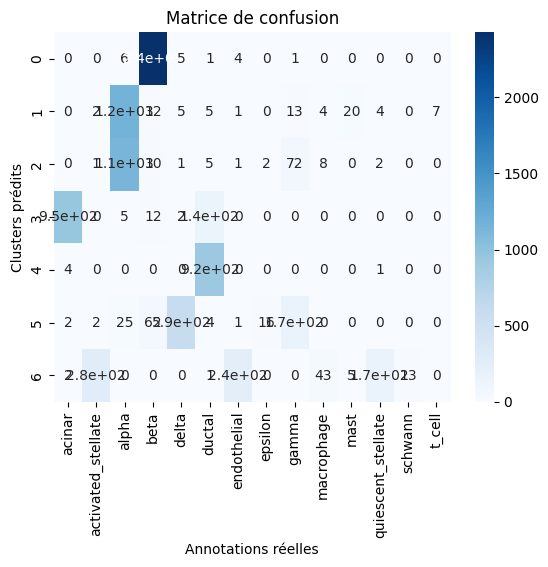

saving model to: model/model.weights.h5
Iter-5: NMI= 0.7975, ARI= 0.7707;  L= 0.47535, Lc= 0.14178,  Lr= 0.33357
Iter-10: NMI= 0.8105, ARI= 0.7794;  L= 0.49442, Lc= 0.15942,  Lr= 0.33500
Iter-15: NMI= 0.8113, ARI= 0.7806;  L= 0.48922, Lc= 0.16344,  Lr= 0.32578
Iter-20: NMI= 0.8159, ARI= 0.7850;  L= 0.48796, Lc= 0.16640,  Lr= 0.32155
Iter-25: NMI= 0.8206, ARI= 0.7883;  L= 0.49350, Lc= 0.17221,  Lr= 0.32129
Iter-30: NMI= 0.8214, ARI= 0.7899;  L= 0.50561, Lc= 0.17781,  Lr= 0.32780
Iter-35: NMI= 0.8193, ARI= 0.7872;  L= 0.50841, Lc= 0.17473,  Lr= 0.33164
Iter-40: NMI= 0.8197, ARI= 0.7865;  L= 0.50865, Lc= 0.17164,  Lr= 0.33523
Iter-45: NMI= 0.8231, ARI= 0.7891;  L= 0.50403, Lc= 0.16993,  Lr= 0.33257
Iter-50: NMI= 0.8185, ARI= 0.7854;  L= 0.50057, Lc= 0.16597,  Lr= 0.33325
Iter-55: NMI= 0.8216, ARI= 0.7858;  L= 0.49413, Lc= 0.16279,  Lr= 0.33019
Iter-60: NMI= 0.8214, ARI= 0.7866;  L= 0.49257, Lc= 0.16102,  Lr= 0.33050
Iter-65: NMI= 0.8195, ARI= 0.7854;  L= 0.49534, Lc= 0.15972,  Lr= 0.33463

In [30]:
y_pred, model=fit(data_ann.X, data_ann.obs,  data_ann.obs.size_factors, data_ann.raw.X, alpha=1.0, n_cluster='auto',batch_size=256,
        max_iter=2e4, tol=1e-3, update_interval=5,
        ae_weights=None, pretrained=False)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 17499)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_6    │ (None, 17499)     │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │  4,480,000 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_7    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_8    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,498,528 (17.16 MB)

 Trainable params: 4,498,528 (17.16 MB)

 Non-trainable params: 0 (0.00 B)

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


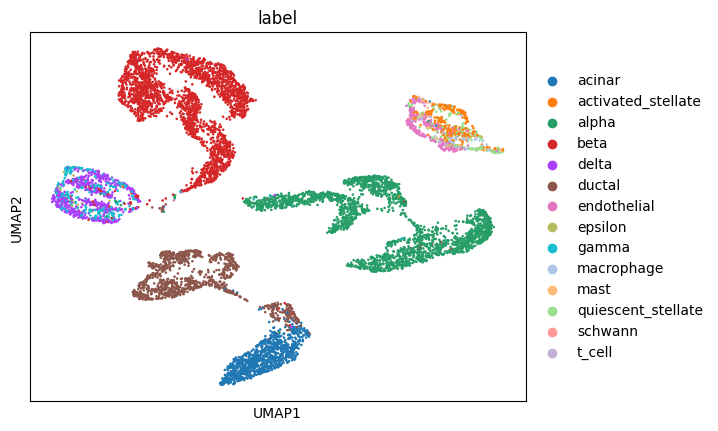

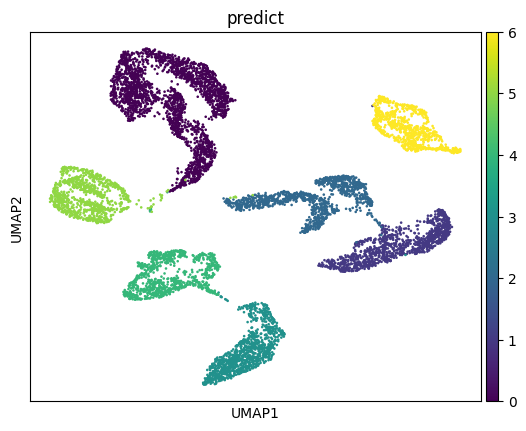

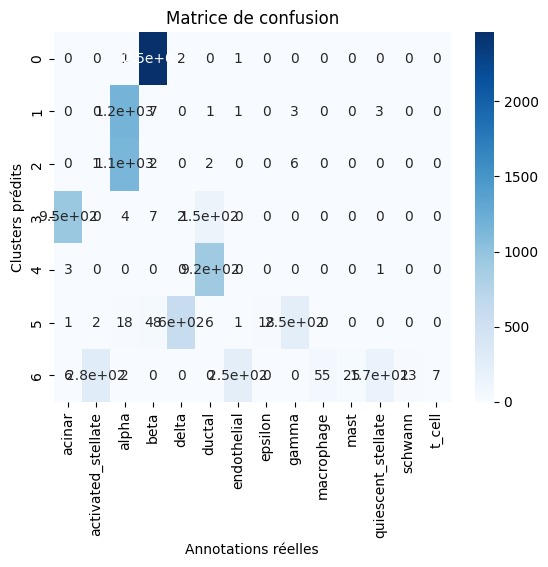

In [31]:
display_latent_space(y_pred, model, data_ann.X , data_ann.obs.size_factors, data_ann.obs)

In [32]:
encoder= Model(inputs=model.input, outputs=model.get_layer("encoder_3").output)
encoder.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer) │ (None, 17499)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_6    │ (None, 17499)     │          0 │ Inputs[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Dense)   │ (None, 256)       │  4,480,000 │ gaussian_noise_6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_7    │ (None, 256)       │          0 │ encoder_1[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2 (Dense)   │ (None, 64)        │     16,448 │ gaussian_noise_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_8    │ (None, 64)        │          0 │ encoder_2[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ size_factors        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_3 (Dense)   │ (None, 32)        │      2,080 │ gaussian_noise_8… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,498,528 (17.16 MB)

 Trainable params: 4,498,528 (17.16 MB)

 Non-trainable params: 0 (0.00 B)

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
La résolution est de :  0.01


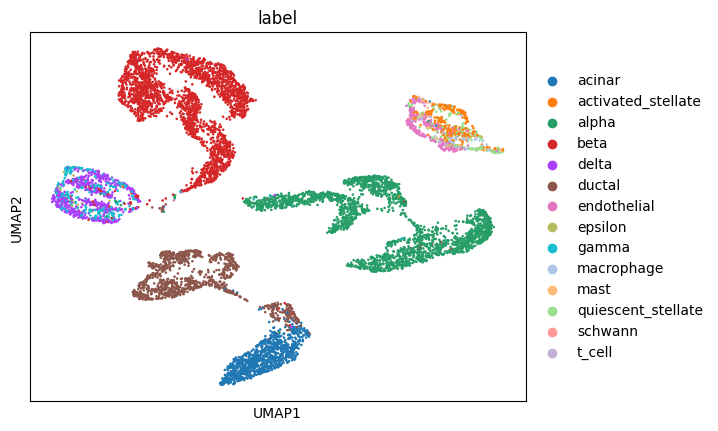

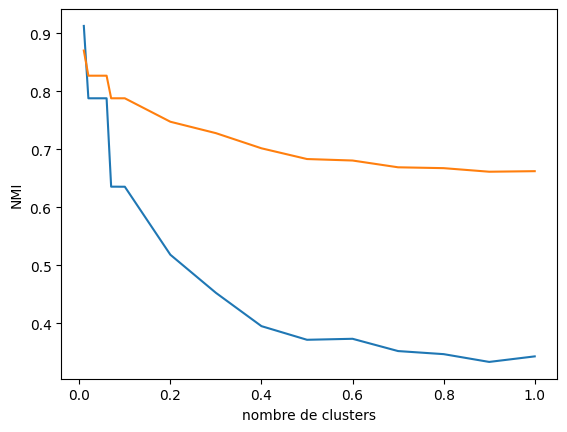

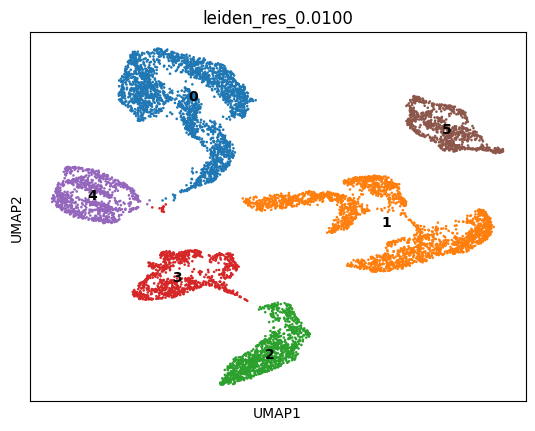

Indice de Rand ajusté (ARI) : 0.9126170225746387
Normalized mutual info (NMI) : 0.8701648348319778


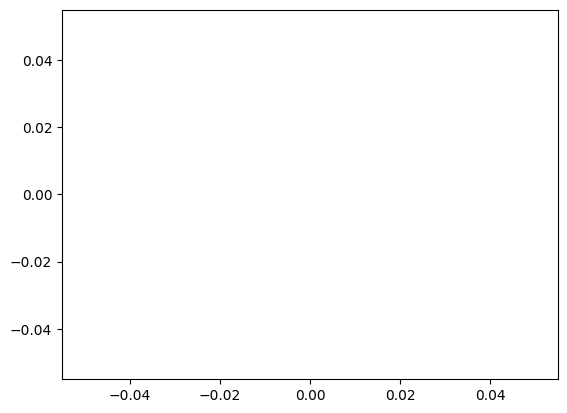

In [33]:
predict, n_clusters, cluster_centers=auto_leiden(encoder, data_ann.X, data_ann.obs.size_factors, data_ann.obs, plot=True)